# OpenAI Gym


In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

import gymnasium as gym

from extravaganza.dynamical_systems import Gym

from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LiftedBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from extravaganza.utils import ylim, render
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpio0v6kyg
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpio0v6kyg/_remote_module_non_scriptable.py


## System
Here, we work with games in the OpenAI gym, such as `MountainCarContinuous-v0`, in which we supply a value in `[-1, 1]` as a control to push a car left or right up a mountain. The tricky thing about this environment is that you first have to push the car up the left to gain momentum, even though the goal is on the right.

Another good environment is the `CartPole` enviroment (left and right bumps on a cart to keep an inverted pendulum upright), whose continuous analog is also displayed below.

We make use of **only the reward signal or cost function** to train, not using any state observation.

MountainCar | CartPole
- | - 
![mountaincar.gif](https://www.gymlibrary.dev/_images/mountain_car.gif) | ![cart_pole.gif](https://www.gymlibrary.dev/_images/cart_pole.gif)

## Hyperparameters

In [2]:
name = 'gym_????'
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 10000  # total timesteps
    T0 = 4000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: t % 400 == 0  # when to reset the system
    use_multiprocessing = False
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    env_name = 'CartPoleContinuous-v1'  
    # env_name = 'MountainCarContinuous-v0'
    repeat = 2  # how many times to repeat each action before a new one can be chosen
    render_env = False

    make_system = lambda : Gym(env_name=env_name, repeat=repeat, render=render_env, seed=SYSTEM_SEED)
    du = make_system().control_dim

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    sysid_method = 'regression'
    sysid_scale = 0.5

    learned_lift_args = {
        'lift_lr': 0.01,
        'sysid_lr': 0.01,
        'cost_lr': 0.001,
        'depth': 6,
        'buffer_maxlen': int(1e6),
        'num_epochs': 75,
        'batch_size': 64,
        'seed': LIFTER_AND_SYSID_SEED
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 20  # controller memory length (# of w's to use on inference)
    hh = 20  # history length of the cost/control histories
    lift_dim = 20  # dimension to lift to

    m_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
    k_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))

    lifted_bpc_args = {
        'h': h,
        'method': 'REINFORCE',
        'initial_scales': (0.001, 0.01, 0.0),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'T0': T0,
        'bounds': (-1, 1),
        'initial_u': jnp.zeros(du),
        'decay_scales': False,
        'use_tanh': False,
        'use_K_from_sysid': False,
        'seed': CONTROLLER_SEED
    }

    make_controllers = {
#         'Zero': lambda sys: ConstantController(0, du),
#         'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, du, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    #     'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
        'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
    }
    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [3]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) ------------------------------

|A| tensor(1.0865, grad_fn=<AmaxBackward0>) tensor(2.3237)
|A-BK| tensor(0.9967, grad_fn=<AmaxBackward0>) tensor(1.2808)
|B| tensor(1., grad_fn=<LinalgVectorNormBackward0>) tensor(0.9614)


INFO: (LEARNEDLIFT) ||A||_op = 2.9794301986694336     ||B||_F 0.9613989591598511


old 0.004289988127927627 new 0.0031100722788382443


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [03:59<00:00, 41.80it/s, control=0.0777, cost=0.0323]
INFO: 
ERROR: (STATS) failed to aggregate only 1 stat
INFO: (EXPERIMENT) done! The entire experiment took 239.51009066600818 seconds


In [4]:
# save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
#                           source code later to see the hyperparameters we chose
experiment.save(filename)

INFO: (EXPERIMENT) saved experiment to `../logs/gym_????.pkl`


## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [5]:
def plot_gym(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 5
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'xs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'us', label=method)
#         stats.plot(ax[1, 1], 'rewards', label=method)
        stats.plot(ax[1, 1], 'fs', label=method)
        stats.plot(ax[2, 0], 'rewards', label=method)
        stats.plot(ax[2, 1], 'avg rewards', label=method)
    
        stats.plot(ax[3, 0], '||A||_op', label=method)
        stats.plot(ax[3, 1], '||B||_F', label=method)
        stats.plot(ax[4, 0], '||A-BK||_op', label=method)
        stats.plot(ax[4, 1], 'lifter losses', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend(); ylim(_ax, -5, 20)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend(); ylim(_ax, -5, 5)
    _ax = ax[1, 0]; _ax.set_title('controls'); _ax.legend(); ylim(_ax, -3, 3)
    _ax = ax[1, 1]; _ax.set_title('costs'); _ax.legend()
    
    _ax = ax[2, 0]; _ax.set_title('instantaneous rewards'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('avg rewards'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[4, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[4, 1]; _ax.set_title('lifter losses'); _ax.legend()
    pass

### Plot

<Figure size 640x480 with 0 Axes>

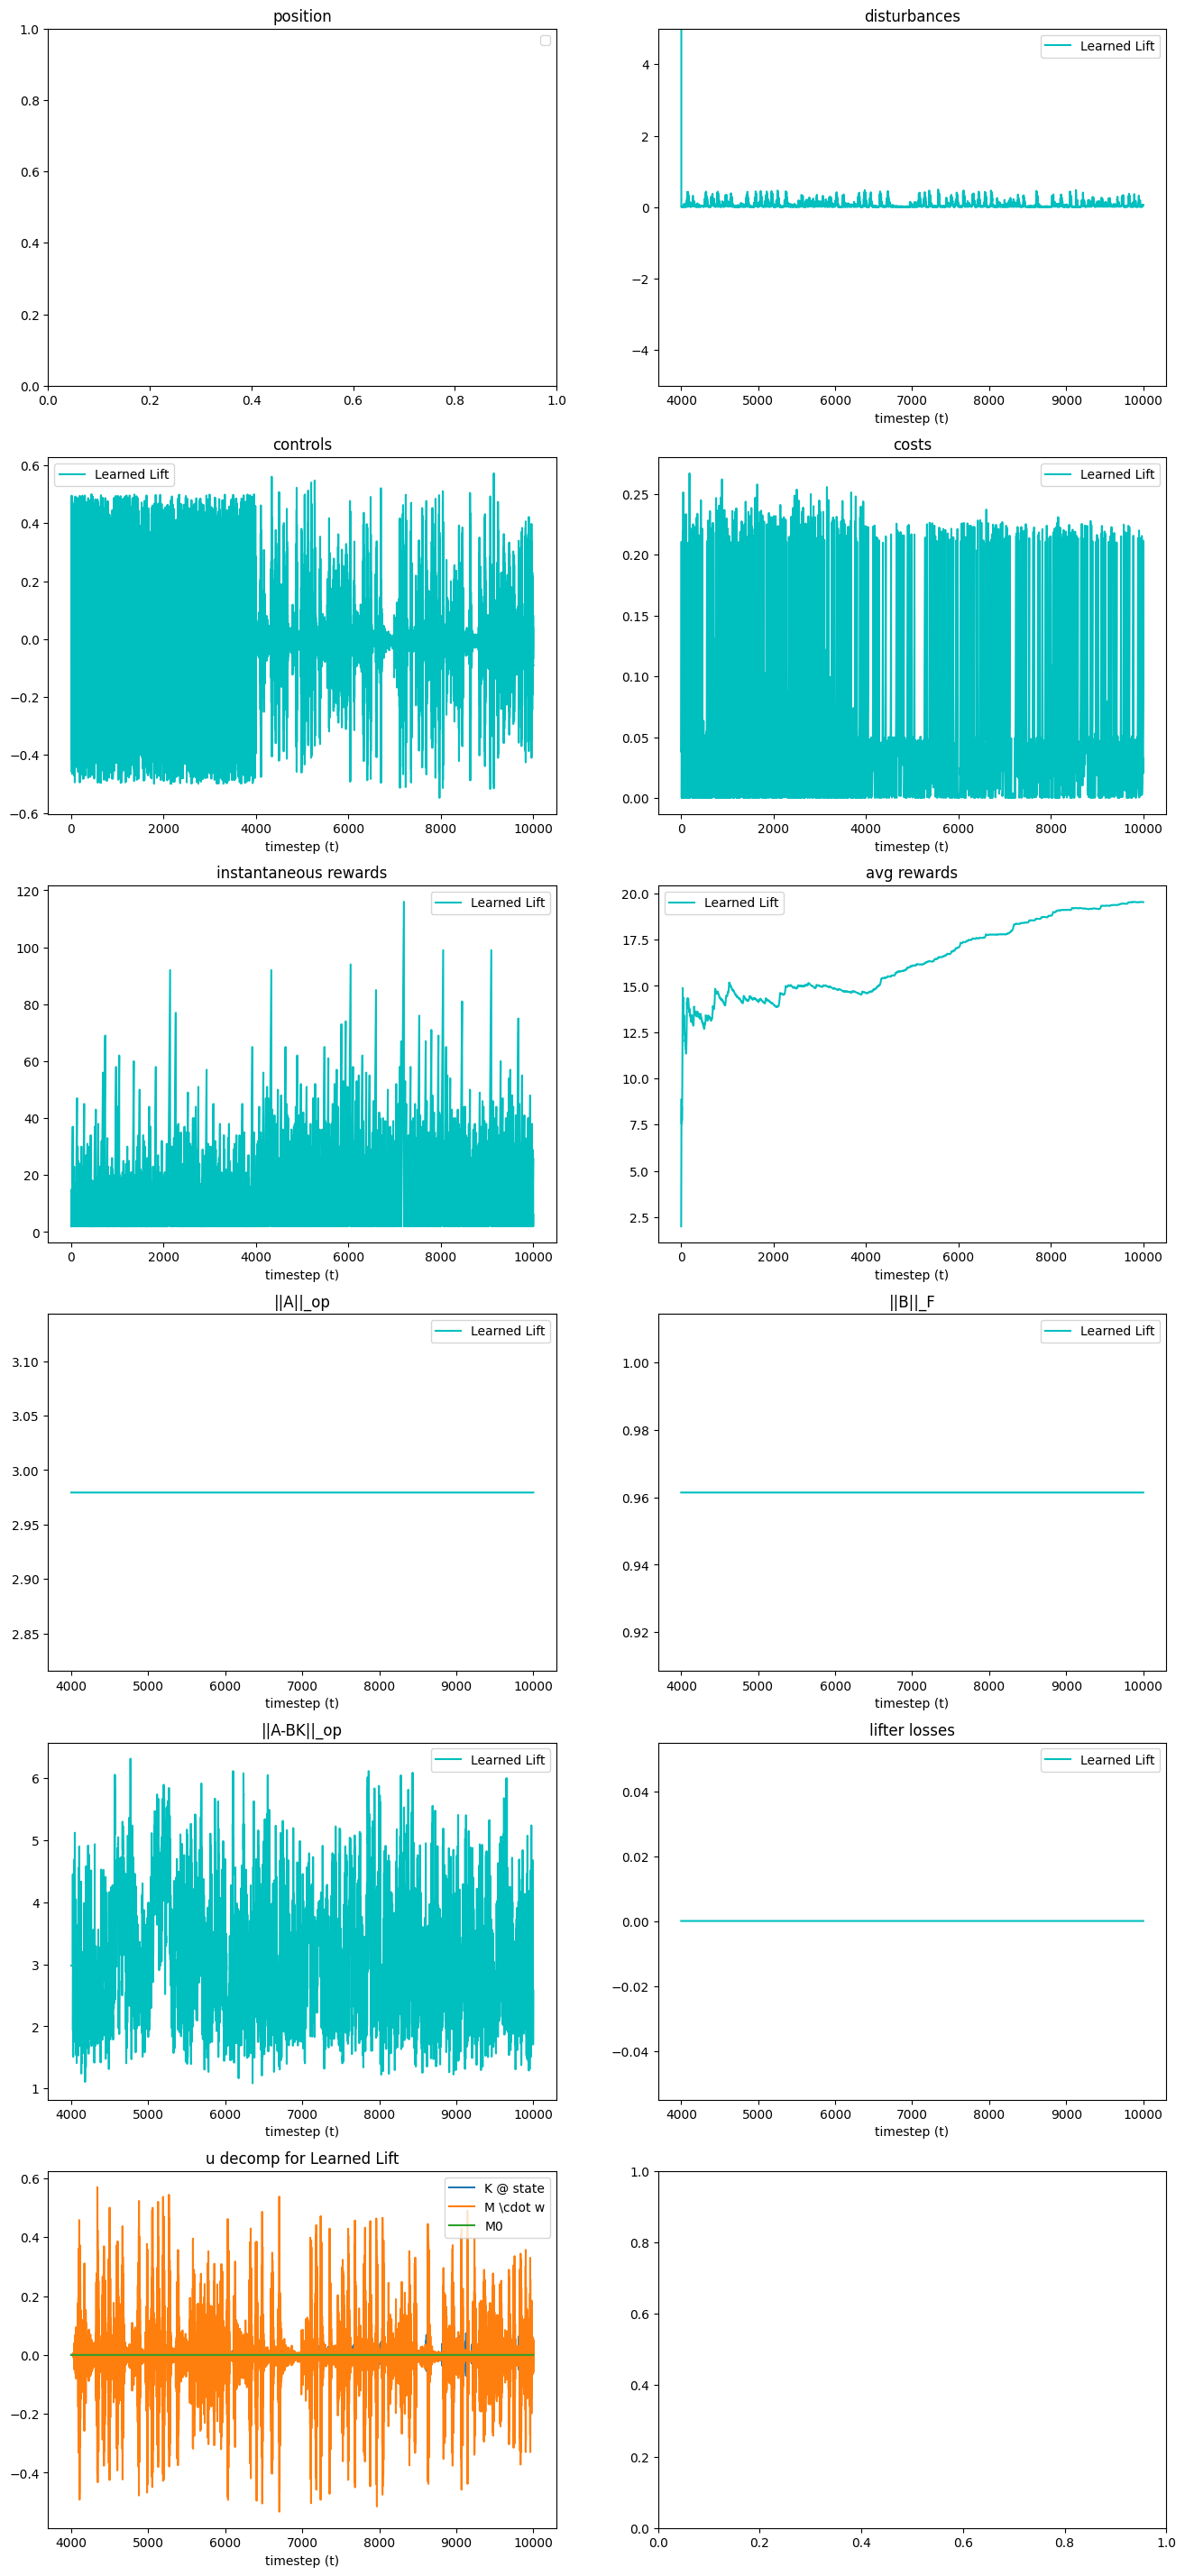

In [8]:
plot_gym(experiment)

# from copy import deepcopy
# e = deepcopy(experiment)
# e.stats = {k: s[8000:8100] for k, s in e.stats.items()}
# plot_gym(e)

### Dynamic Plot

INFO: (RENDERER): rendering the stats of the following: ['Learned Lift']


AssertionError: unknown key(s)

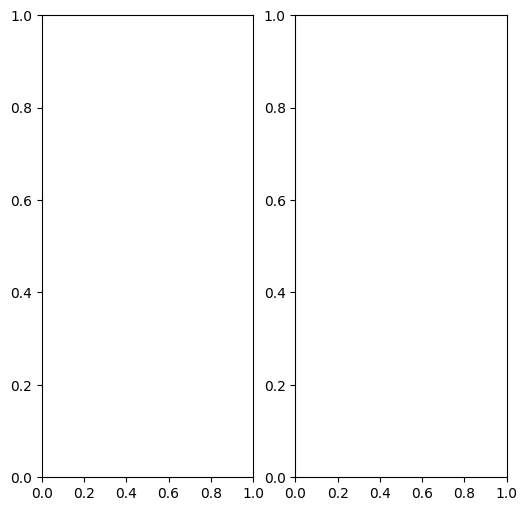

In [7]:
# dynamic plot
anim = render(experiment, 'xs', 'fs', sliderkey='us', save_path=None, duration=5, fps=30)
vid = anim.to_html5_video()
HTML(vid)